# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [var_smoothing](#var_smoothing)
* [Discussion](#Discussion)

# Introduction

After rounds of feature engineering, visualization & exploration, and tuning various aspects of the classification pipeline, we are about to create a prototype classifier using a bagged GaussianNB. In this notebook, we perform grid searches over var_smoothing using out-of-bag accuracy instead of cross validation.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# typing
from typing import Sequence

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.15 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = (
    "../24.0-mic-train_new_prototypes_with_simplified_pipeline_and_no_song_data"
)

# Location where this notebook will output
DATA_OUT_FOLDER = "./tune_GNB"

_ = gc_collect()

time: 93.8 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather("./scaled_features_ready_for_selection.feather").set_index(
        "id"
    )
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
_ = gc_collect()

time: 214 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 41 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           85740 non-null  float64
 1   LDA2                                                                           85740 non-null  float64
 2   ocLDA_neg                                                                      85740 non-null  float64
 3   ocLDA_neu                                                                      85740 non-null  float64
 4   ocLDA_pos                                                                      85740 non-null  float64
 5   ocSVM_sgdlinear_LDA1                                                           85740 non-null  float64
 6   ocSVM_sgdlinear_LDA2 

In [7]:
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
_ = gc_collect()

time: 102 ms


# var_smoothing

In [8]:
def tune_var_smoothing(search_space: Sequence, outfile: str) -> None:
    """Run tuning procedure"""
    df = deepcopy(data)
    make_gnb = lambda var_smoothing: BaggingClassifier(
        base_estimator=GaussianNB(var_smoothing=var_smoothing),
        n_estimators=50,
        oob_score=True,
        n_jobs=-1,
        random_state=SEED,
    ).fit(df, y_true)
    for hp in tqdm(search_space):
        gnb = make_gnb(hp)
        results["var_smoothing"].append(hp)
        results["oob_score"].append(gnb.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

    df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
    print(df.sort_values(by="oob_score", ascending=False).head(10))
    print(df.sort_values(by="log_loss", ascending=True).head(10))
    print(df.sort_values(by="auroc", ascending=False).head(10))
    df.plot(x="var_smoothing")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

    df.columns = df.columns.astype(str)
    df.reset_index(drop=True).to_feather(f"{DATA_OUT_FOLDER}/{outfile}.feather")
    del df


_ = gc_collect()

time: 91.6 ms


  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
2        0.034015   0.680231  1.405232  0.829554
19       0.028930   0.678773  1.522393  0.829867
48       0.024178   0.676487  1.666947  0.830156
40       0.024416   0.676300  1.658676  0.830141
28       0.063658   0.673513  1.078450  0.827871
3        0.014992   0.670189  2.116895  0.830658
41       0.012735   0.667786  2.286104  0.830759
33       0.011346   0.666550  2.408514  0.830814
21       0.087750   0.663529  0.983286  0.826785
42       0.089039   0.662876  0.979971  0.826733
    var_smoothing  oob_score  log_loss     auroc
18       0.293259   0.597924  0.884370  0.823309
32       0.292773   0.597982  0.884370  0.823310
39       0.289465   0.598227  0.884376  0.823321
13       0.287113   0.598507  0.884384  0.823329
37       0.274353   0.600420  0.884501  0.823381
49       0.269499   0.601330  0.884581  0.823404
6        0.269297   0.601365  0.884585  0.823405
8        0.269089   0.601376  0.884589  0.823406
26       0.259331   

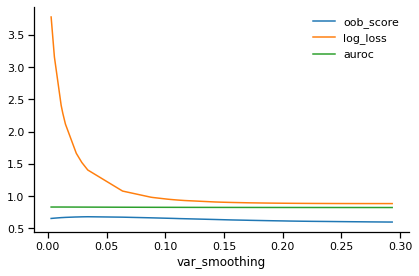

time: 8min 7s


In [9]:
tune_var_smoothing(
    search_space=np.random.uniform(0.0, 0.3, size=50), outfile="var_smoothing1"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
2        0.034015   0.680231  1.405232  0.829554
59       0.030153   0.679158  1.491193  0.829792
19       0.028930   0.678773  1.522393  0.829867
48       0.024178   0.676487  1.666947  0.830156
74       0.023798   0.676452  1.680390  0.830178
40       0.024416   0.676300  1.658676  0.830141
28       0.063658   0.673513  1.078450  0.827871
87       0.017340   0.672218  1.971406  0.830542
95       0.015327   0.670469  2.094413  0.830641
3        0.014992   0.670189  2.116895  0.830658
    var_smoothing  oob_score  log_loss     auroc
18       0.293259   0.597924  0.884370  0.823309
32       0.292773   0.597982  0.884370  0.823310
69       0.298076   0.597457  0.884373  0.823295
39       0.289465   0.598227  0.884376  0.823321
13       0.287113   0.598507  0.884384  0.823329
66       0.304265   0.596583  0.884399  0.823280
37       0.274353   0.600420  0.884501  0.823381
49       0.269499   0.601330  0.884581  0.823404
6        0.269297   

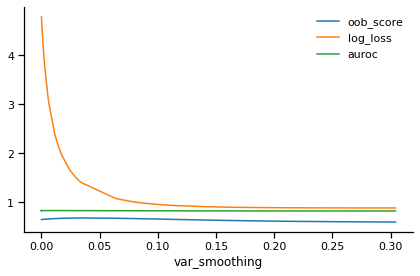

time: 7min 52s


In [10]:
tune_var_smoothing(
    search_space=loguniform.rvs(1e-11, 0.4, size=50), outfile="var_smoothing2"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
2        0.034015   0.680231  1.405232  0.829554
59       0.030153   0.679158  1.491193  0.829792
19       0.028930   0.678773  1.522393  0.829867
48       0.024178   0.676487  1.666947  0.830156
74       0.023798   0.676452  1.680390  0.830178
40       0.024416   0.676300  1.658676  0.830141
28       0.063658   0.673513  1.078450  0.827871
87       0.017340   0.672218  1.971406  0.830542
95       0.015327   0.670469  2.094413  0.830641
3        0.014992   0.670189  2.116895  0.830658
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280
137       0

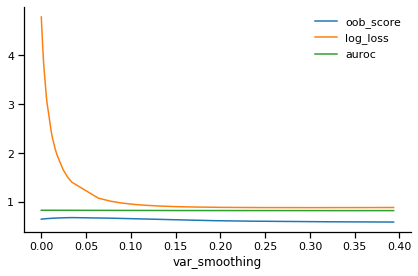

time: 7min 52s


In [11]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.1, 0.4, size=50), outfile="var_smoothing3"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
199       0.032932   0.679974  1.427606  0.829621
152       0.033137   0.679963  1.423272  0.829608
59        0.030153   0.679158  1.491193  0.829792
166       0.029262   0.678855  1.513705  0.829847
19        0.028930   0.678773  1.522393  0.829867
186       0.027849   0.678108  1.551820  0.829933
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


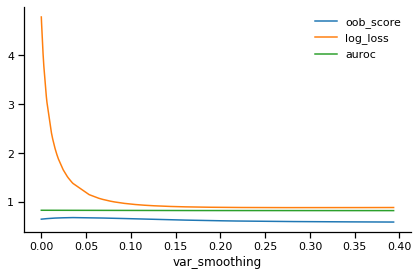

time: 7min 43s


In [12]:
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 0.25, size=50), outfile="var_smoothing4"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
153       0.034744   0.680383  1.390871  0.829509
163       0.035371   0.680383  1.378941  0.829470
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
199       0.032932   0.679974  1.427606  0.829621
152       0.033137   0.679963  1.423272  0.829608
59        0.030153   0.679158  1.491193  0.829792
166       0.029262   0.678855  1.513705  0.829847
19        0.028930   0.678773  1.522393  0.829867
186       0.027849   0.678108  1.551820  0.829933
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


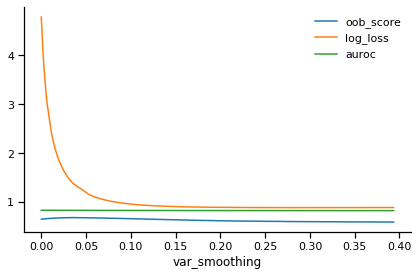

time: 7min 32s


In [13]:
tune_var_smoothing(
    search_space=np.random.uniform(0.05, 0.15, size=50), outfile="var_smoothing5"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
261       0.034606   0.680418  1.393541  0.829517
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
267       0.036216   0.680021  1.363457  0.829417
199       0.032932   0.679974  1.427606  0.829621
152       0.033137   0.679963  1.423272  0.829608
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


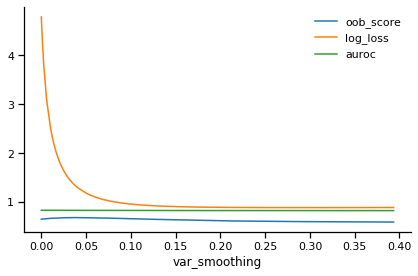

time: 7min 58s


In [14]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 0.25, size=50), outfile="var_smoothing6"
)

  0%|          | 0/15 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
261       0.034606   0.680418  1.393541  0.829517
153       0.034744   0.680383  1.390871  0.829509
163       0.035371   0.680383  1.378941  0.829470
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
301       0.033469   0.680044  1.416352  0.829588
267       0.036216   0.680021  1.363457  0.829417
199       0.032932   0.679974  1.427606  0.829621
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


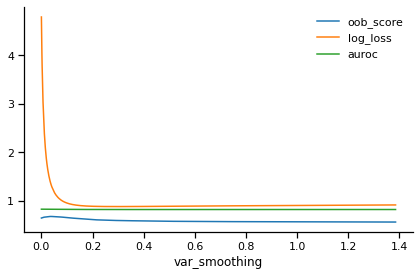

  0%|          | 0/15 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
261       0.034606   0.680418  1.393541  0.829517
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
301       0.033469   0.680044  1.416352  0.829588
267       0.036216   0.680021  1.363457  0.829417
199       0.032932   0.679974  1.427606  0.829621
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


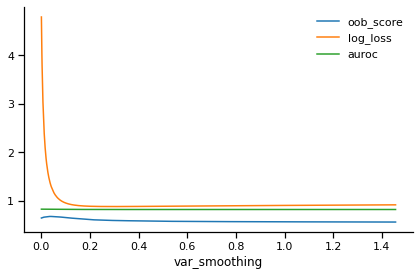

time: 4min 39s


In [15]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 1.5, size=15), outfile="var_smoothing7"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 1.5, size=15), outfile="var_smoothing8"
)

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
261       0.034606   0.680418  1.393541  0.829517
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
301       0.033469   0.680044  1.416352  0.829588
267       0.036216   0.680021  1.363457  0.829417
199       0.032932   0.679974  1.427606  0.829621
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


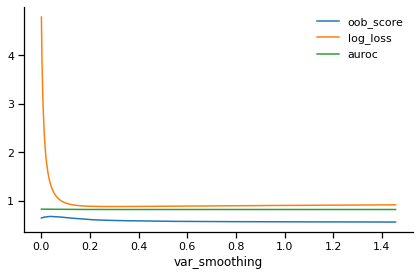

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
261       0.034606   0.680418  1.393541  0.829517
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
301       0.033469   0.680044  1.416352  0.829588
267       0.036216   0.680021  1.363457  0.829417
199       0.032932   0.679974  1.427606  0.829621
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


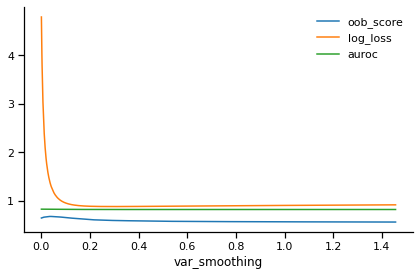

time: 4min 42s


In [16]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.12, 0.17, size=11), outfile="var_smoothing9"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.12, 0.17, size=11), outfile="var_smoothing10"
)

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
261       0.034606   0.680418  1.393541  0.829517
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
301       0.033469   0.680044  1.416352  0.829588
267       0.036216   0.680021  1.363457  0.829417
199       0.032932   0.679974  1.427606  0.829621
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329
66        0.304265   0.596583  0.884399  0.823280


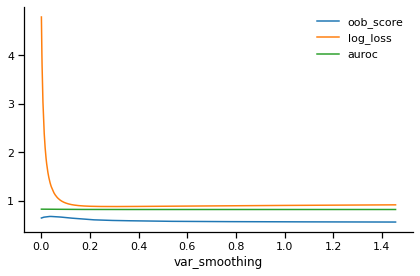

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
261       0.034606   0.680418  1.393541  0.829517
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
301       0.033469   0.680044  1.416352  0.829588
267       0.036216   0.680021  1.363457  0.829417
199       0.032932   0.679974  1.427606  0.829621
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
366       0.296975   0.597551  0.884371  0.823298
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329


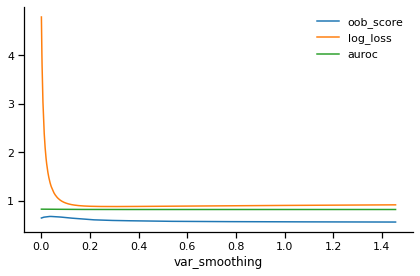

time: 6min 13s


In [17]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.2, 0.4, size=11), outfile="var_smoothing11"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.2, 0.4, size=11), outfile="var_smoothing12"
)

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
377       0.035465   0.680441  1.377197  0.829464
261       0.034606   0.680418  1.393541  0.829517
375       0.035406   0.680406  1.378292  0.829468
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
301       0.033469   0.680044  1.416352  0.829588
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
366       0.296975   0.597551  0.884371  0.823298
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329


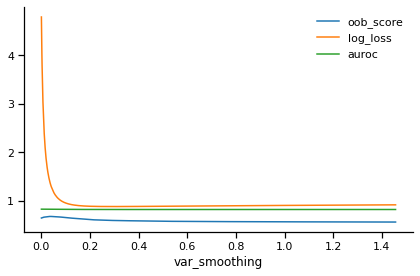

  0%|          | 0/11 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
377       0.035465   0.680441  1.377197  0.829464
261       0.034606   0.680418  1.393541  0.829517
375       0.035406   0.680406  1.378292  0.829468
153       0.034744   0.680383  1.390871  0.829509
163       0.035371   0.680383  1.378941  0.829470
194       0.034717   0.680359  1.391393  0.829510
390       0.034001   0.680231  1.405515  0.829555
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
366       0.296975   0.597551  0.884371  0.823298
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329


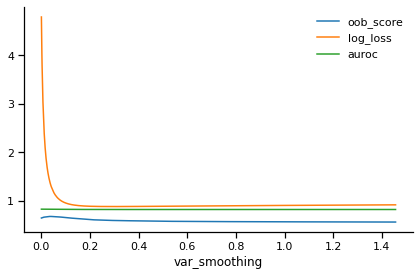

time: 3min 2s


In [18]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.02, 0.04, size=11), outfile="var_smoothing13"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.02, 0.04, size=11), outfile="var_smoothing14"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
377       0.035465   0.680441  1.377197  0.829464
261       0.034606   0.680418  1.393541  0.829517
375       0.035406   0.680406  1.378292  0.829468
153       0.034744   0.680383  1.390871  0.829509
163       0.035371   0.680383  1.378941  0.829470
194       0.034717   0.680359  1.391393  0.829510
390       0.034001   0.680231  1.405515  0.829555
2         0.034015   0.680231  1.405232  0.829554
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
     var_smoothing  oob_score  log_loss     auroc
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
366       0.296975   0.597551  0.884371  0.823298
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295
39        0.289465   0.598227  0.884376  0.823321
13        0.287113   0.598507  0.884384  0.823329


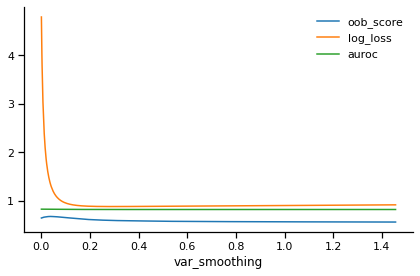

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
377       0.035465   0.680441  1.377197  0.829464
261       0.034606   0.680418  1.393541  0.829517
375       0.035406   0.680406  1.378292  0.829468
163       0.035371   0.680383  1.378941  0.829470
153       0.034744   0.680383  1.390871  0.829509
194       0.034717   0.680359  1.391393  0.829510
2         0.034015   0.680231  1.405232  0.829554
390       0.034001   0.680231  1.405515  0.829555
258       0.033898   0.680208  1.407600  0.829561
293       0.037646   0.680161  1.338674  0.829329
     var_smoothing  oob_score  log_loss     auroc
456       0.296014   0.597644  0.884370  0.823301
490       0.294163   0.597796  0.884370  0.823306
18        0.293259   0.597924  0.884370  0.823309
32        0.292773   0.597982  0.884370  0.823310
102       0.292614   0.597971  0.884370  0.823311
366       0.296975   0.597551  0.884371  0.823298
109       0.291313   0.598064  0.884372  0.823315
69        0.298076   0.597457  0.884373  0.823295


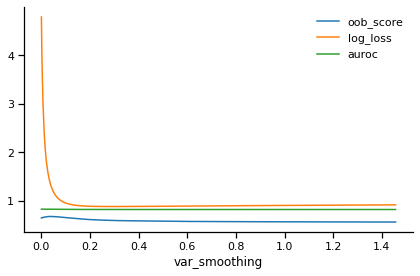

time: 13min 40s


In [19]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 0.5, size=50), outfile="var_smoothing15"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 0.5, size=50), outfile="var_smoothing16"
)

In [20]:
_ = gc_collect()

time: 676 ms


In [21]:
files = [
    "var_smoothing1.feather",
    "var_smoothing2.feather",
    "var_smoothing3.feather",
    "var_smoothing4.feather",
    "var_smoothing5.feather",
    "var_smoothing6.feather",
    "var_smoothing7.feather",
    "var_smoothing8.feather",
    "var_smoothing9.feather",
    "var_smoothing10.feather",
    "var_smoothing11.feather",
    "var_smoothing12.feather",
    "var_smoothing13.feather",
    "var_smoothing14.feather",
    "var_smoothing15.feather",
    "var_smoothing16.feather",
]
df = pd.concat(
    [pd.read_feather(f"{DATA_OUT_FOLDER}/{file}") for file in files],
    axis="rows",
)

time: 33.9 ms


<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

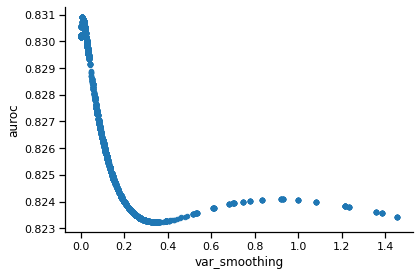

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

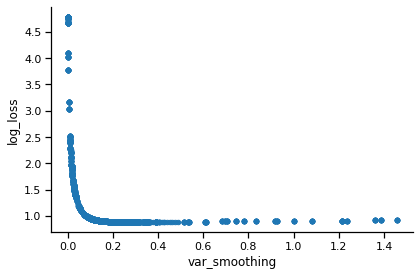

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

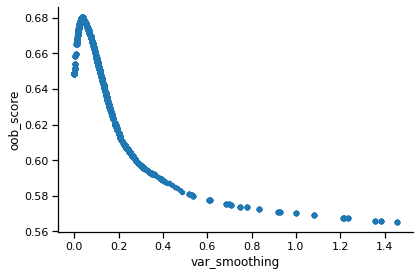

time: 856 ms


In [22]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.sort_values(by="var_smoothing").plot(x="var_smoothing", y=metric, kind="scatter")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [23]:
# best
df = df.drop_duplicates()
df.loc[df.log_loss == df.log_loss.min()]
df.loc[df.oob_score == df.oob_score.max()].sort_values(by="log_loss", ascending=True)
df.loc[df.auroc == df.auroc.max()]

,var_smoothing,oob_score,log_loss,auroc
426,0.296014,0.597644,0.88437,0.823301


,var_smoothing,oob_score,log_loss,auroc
97,0.035465,0.680441,1.377197,0.829464


,var_smoothing,oob_score,log_loss,auroc
41,0.006305,0.659377,3.036293,0.83091


time: 31 ms


In [24]:
# next best
df.sort_values(by="log_loss", ascending=True).head(11).tail(10)
df.sort_values(by="oob_score", ascending=False).head(11).tail(10)
df.sort_values(by="auroc", ascending=False).head(11).tail(10)

,var_smoothing,oob_score,log_loss,auroc
425,0.294163,0.597796,0.884370,0.823306
49,0.293259,0.597924,0.884370,0.823309
48,0.292773,0.597982,0.884370,0.823310
135,0.292614,0.597971,0.884370,0.823311
335,0.296975,0.597551,0.884371,0.823298
134,0.291313,0.598064,0.884372,0.823315
98,0.298076,0.597457,0.884373,0.823295
47,0.289465,0.598227,0.884376,0.823321
46,0.287113,0.598507,0.884384,0.823329
99,0.304265,0.596583,0.884399,0.823280


,var_smoothing,oob_score,log_loss,auroc
81,0.034606,0.680418,1.393541,0.829517
96,0.035406,0.680406,1.378292,0.829468
60,0.034744,0.680383,1.390871,0.829509
61,0.035371,0.680383,1.378941,0.829470
59,0.034717,0.680359,1.391393,0.829510
99,0.034001,0.680231,1.405515,0.829555
8,0.034015,0.680231,1.405232,0.829554
79,0.033898,0.680208,1.407600,0.829561
86,0.037646,0.680161,1.338674,0.829329
110,0.037259,0.680056,1.345220,0.829353


,var_smoothing,oob_score,log_loss,auroc
1,0.005599,0.658269,3.157899,0.830892
42,0.010266,0.665325,2.515697,0.830852
43,0.010291,0.665372,2.513032,0.830851
43,0.010322,0.665407,2.509758,0.830851
45,0.010583,0.665640,2.483019,0.830842
46,0.010673,0.665629,2.473854,0.830839
44,0.010950,0.665862,2.446484,0.830829
44,0.011018,0.665990,2.439812,0.830827
42,0.011304,0.666503,2.412508,0.830816
2,0.011346,0.666550,2.408514,0.830814


time: 26 ms


In [25]:
df["diff"] = df.log_loss - df.oob_score
df.sort_values(by="diff", ascending=True).head(10)

,var_smoothing,oob_score,log_loss,auroc,diff
219,0.161739,0.628831,0.899709,0.824610,0.270878
26,0.169402,0.625951,0.896959,0.824465,0.271008
236,0.164652,0.627583,0.898606,0.824553,0.271023
245,0.163190,0.628120,0.899150,0.824581,0.271030
123,0.160941,0.628995,0.900025,0.824626,0.271031
319,0.160155,0.629286,0.900341,0.824641,0.271055
217,0.160515,0.629135,0.900195,0.824634,0.271061
247,0.165631,0.627175,0.898252,0.824534,0.271077
232,0.159812,0.629403,0.900480,0.824648,0.271078
302,0.158580,0.629893,0.900992,0.824673,0.271099


time: 11 ms


In [30]:
df["diff2"] = df.log_loss - df.auroc
df.sort_values(by="diff2", ascending=True).head(10)

,var_smoothing,oob_score,log_loss,auroc,diff,diff2
47,0.289465,0.598227,0.884376,0.823321,0.286148,0.061054
46,0.287113,0.598507,0.884384,0.823329,0.285877,0.061055
134,0.291313,0.598064,0.884372,0.823315,0.286308,0.061056
135,0.292614,0.597971,0.884370,0.823311,0.286400,0.061060
48,0.292773,0.597982,0.884370,0.823310,0.286388,0.061060
49,0.293259,0.597924,0.884370,0.823309,0.286446,0.061061
425,0.294163,0.597796,0.884370,0.823306,0.286574,0.061064
328,0.282162,0.599160,0.884412,0.823348,0.285252,0.061065
131,0.282121,0.599172,0.884413,0.823348,0.285241,0.061065
426,0.296014,0.597644,0.884370,0.823301,0.286726,0.061069


time: 14.9 ms


In [38]:
good_df = df.loc[df.var_smoothing < 0.2]

time: 2.01 ms


In [39]:
good_df.sort_values(by="oob_score", ascending=False).head(10)
good_df.sort_values(by="log_loss", ascending=True).head(10)
good_df.sort_values(by="auroc", ascending=False).head(10)
good_df.sort_values(by="diff", ascending=True).head(10)
good_df.sort_values(by="diff2", ascending=True).head(10)

,var_smoothing,oob_score,log_loss,auroc,diff,diff2
97,0.035465,0.680441,1.377197,0.829464,0.696756,0.547733
81,0.034606,0.680418,1.393541,0.829517,0.713124,0.564024
96,0.035406,0.680406,1.378292,0.829468,0.697886,0.548824
61,0.035371,0.680383,1.378941,0.829470,0.698558,0.549471
60,0.034744,0.680383,1.390871,0.829509,0.710488,0.561362
59,0.034717,0.680359,1.391393,0.829510,0.711034,0.561883
99,0.034001,0.680231,1.405515,0.829555,0.725284,0.575960
8,0.034015,0.680231,1.405232,0.829554,0.725001,0.575678
79,0.033898,0.680208,1.407600,0.829561,0.727393,0.578039
86,0.037646,0.680161,1.338674,0.829329,0.658513,0.509345


,var_smoothing,oob_score,log_loss,auroc,diff,diff2
140,0.199972,0.615489,0.889818,0.823990,0.274329,0.065829
139,0.199966,0.615489,0.889819,0.823990,0.274330,0.065829
105,0.194680,0.617087,0.890720,0.824060,0.273633,0.066659
29,0.194236,0.617203,0.890801,0.824066,0.273597,0.066734
103,0.191199,0.618148,0.891375,0.824109,0.273227,0.067265
135,0.189513,0.618521,0.891710,0.824134,0.273188,0.067576
102,0.188422,0.618871,0.891934,0.824150,0.273063,0.067784
231,0.187734,0.619291,0.892079,0.824160,0.272788,0.067919
101,0.186325,0.619641,0.892384,0.824182,0.272743,0.068202
28,0.185829,0.619862,0.892493,0.824189,0.272631,0.068304


,var_smoothing,oob_score,log_loss,auroc,diff,diff2
41,0.006305,0.659377,3.036293,0.830910,2.376916,2.205382
1,0.005599,0.658269,3.157899,0.830892,2.499630,2.327007
42,0.010266,0.665325,2.515697,0.830852,1.850371,1.684844
43,0.010291,0.665372,2.513032,0.830851,1.847660,1.682181
43,0.010322,0.665407,2.509758,0.830851,1.844351,1.678907
45,0.010583,0.665640,2.483019,0.830842,1.817379,1.652177
46,0.010673,0.665629,2.473854,0.830839,1.808226,1.643015
44,0.010950,0.665862,2.446484,0.830829,1.780622,1.615654
44,0.011018,0.665990,2.439812,0.830827,1.773822,1.608985
42,0.011304,0.666503,2.412508,0.830816,1.746005,1.581692


,var_smoothing,oob_score,log_loss,auroc,diff,diff2
219,0.161739,0.628831,0.899709,0.824610,0.270878,0.075099
26,0.169402,0.625951,0.896959,0.824465,0.271008,0.072494
236,0.164652,0.627583,0.898606,0.824553,0.271023,0.074053
245,0.163190,0.628120,0.899150,0.824581,0.271030,0.074568
123,0.160941,0.628995,0.900025,0.824626,0.271031,0.075400
319,0.160155,0.629286,0.900341,0.824641,0.271055,0.075699
217,0.160515,0.629135,0.900195,0.824634,0.271061,0.075561
247,0.165631,0.627175,0.898252,0.824534,0.271077,0.073718
232,0.159812,0.629403,0.900480,0.824648,0.271078,0.075832
302,0.158580,0.629893,0.900992,0.824673,0.271099,0.076318


,var_smoothing,oob_score,log_loss,auroc,diff,diff2
140,0.199972,0.615489,0.889818,0.823990,0.274329,0.065829
139,0.199966,0.615489,0.889819,0.823990,0.274330,0.065829
105,0.194680,0.617087,0.890720,0.824060,0.273633,0.066659
29,0.194236,0.617203,0.890801,0.824066,0.273597,0.066734
103,0.191199,0.618148,0.891375,0.824109,0.273227,0.067265
135,0.189513,0.618521,0.891710,0.824134,0.273188,0.067576
102,0.188422,0.618871,0.891934,0.824150,0.273063,0.067784
231,0.187734,0.619291,0.892079,0.824160,0.272788,0.067919
101,0.186325,0.619641,0.892384,0.824182,0.272743,0.068202
28,0.185829,0.619862,0.892493,0.824189,0.272631,0.068304


time: 76 ms


<AxesSubplot:xlabel='var_smoothing'>

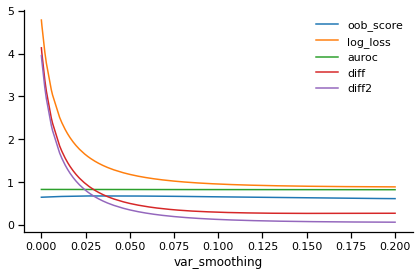

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

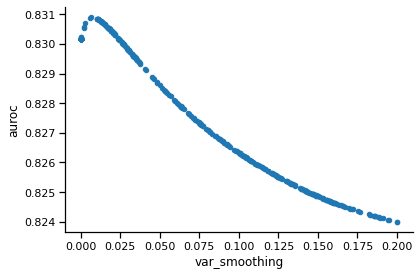

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

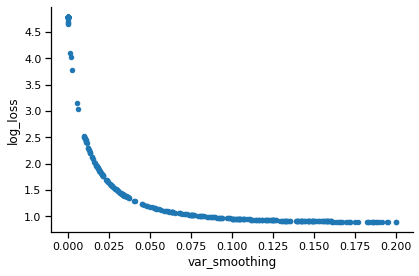

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

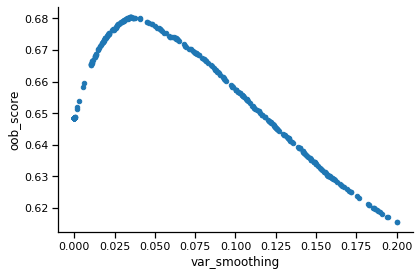

time: 859 ms


In [40]:
# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='var_smoothing'>

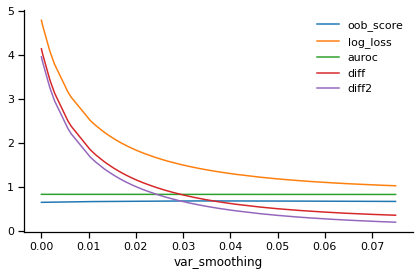

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

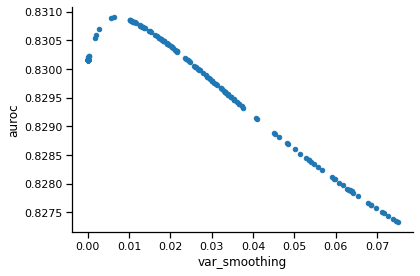

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

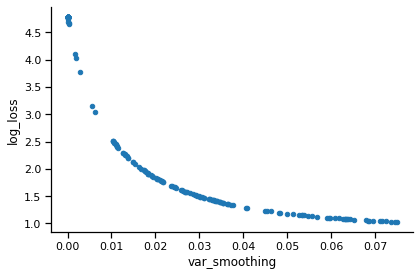

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

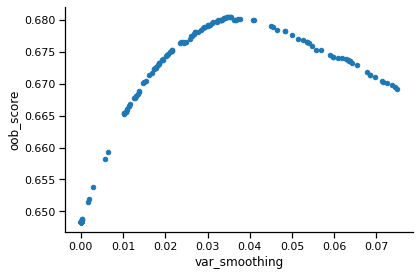

time: 879 ms


In [41]:
max_val = 0.075
good_df = good_df.loc[good_df.var_smoothing < max_val]

# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='var_smoothing'>

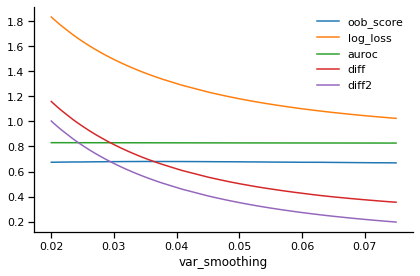

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

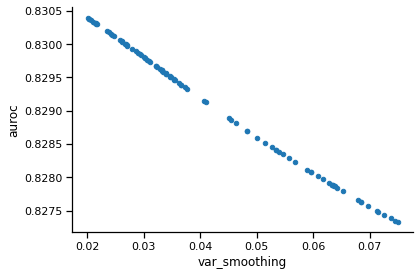

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

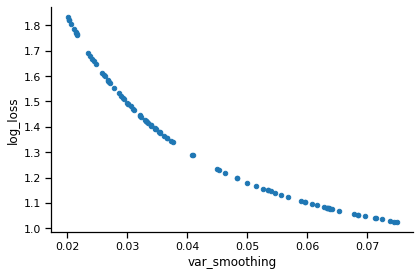

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

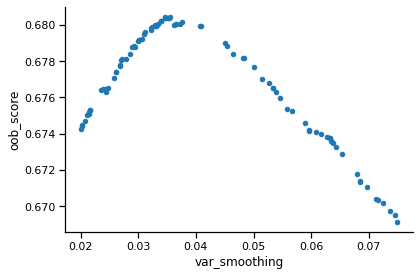

time: 812 ms


In [42]:
min_val = 0.02
good_df = good_df.loc[good_df.var_smoothing > min_val]

# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [51]:
chosen_var_smoothing = good_df.loc[
    good_df.oob_score == good_df.oob_score.max()
].var_smoothing
assert len(chosen_var_smoothing) == 1
chosen_var_smoothing = chosen_var_smoothing.iloc[0]
chosen_var_smoothing

0.035464512306105304

time: 4.98 ms


In [46]:
final_gnb = BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=chosen_var_smoothing),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)
_ = gc_collect()

time: 142 ms


In [47]:
final_gnb.fit(data, labels.valence)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.4s remaining:   19.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.7s finished


BaggingClassifier(base_estimator=GaussianNB(var_smoothing=0.035464512306105304),
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=2022,
                  verbose=1)

time: 9.68 s


In [48]:
final_gnb.oob_score_
log_loss(y_true, final_gnb.predict_proba(data))
roc_auc_score(y_true, final_gnb.predict_proba(data), multi_class="ovo")

0.680440867739678

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s finished


1.377196724794654

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished


0.829463652294657

time: 6.35 s


# Discussion

We chose based on OOB accuracy ultimately.

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [49]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 23660.467036247253 s
time: 123 ms


[^top](#Contents)